<a href="https://colab.research.google.com/github/unclepeddy/deeplearning/blob/master/6-misc-examples/transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
! pip install -q tf-nightly-gpu-2.0-preview

%load_ext tensorboard

In [29]:
import datetime
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import os

print(tf.__version__)

2.0.0-dev20190422


In [0]:
# Set hyperparams

image_size = (224, 224)
batch_size = 4

In [43]:
# Download dataset
dataset_path = "https://storage.googleapis.com/peddy-ai-dl-data/deeplearning-repo/sleepy.tar"
data_root = tf.keras.utils.get_file("sleepy", dataset_path, untar=True)
train_dir = os.path.join(data_root, "train")
test_dir = os.path.join(data_root, "test")

# Create DataGenerators for training and validation
train_image_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1/255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')
test_image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)


train_image_data = train_image_generator.flow_from_directory(train_dir, 
                                                             target_size=image_size)
test_image_data = test_image_generator.flow_from_directory(test_dir, 
                                                           target_size=image_size)
assert train_image_data.num_classes == 2
assert test_image_data.num_classes == 2

train_image_data.batch_size = batch_size

107012096/107008000 [==============================] - 1s 0us/step
Found 41 images belonging to 2 classes.
Found 8 images belonging to 2 classes.


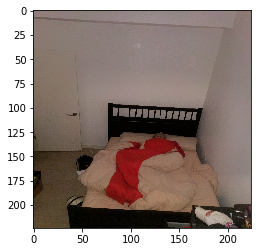

In [44]:
# Plot a sample image
sample_images, sample_targets = test_image_data.next()
plt.plot()
plt.imshow(sample_images[0])
test_image_data.reset()

In [0]:
# Download headless MobileNet model and freeze all trainable parameters
feature_extractor_url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/2" 
#feature_extractor_url = "https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/2"
feature_extractor_layer = hub.KerasLayer(feature_extractor_url, input_shape=(image_size + (3,)))
feature_extractor_layer.trainable = False

In [22]:
classifier = tf.keras.Sequential([
    feature_extractor_layer
])

labels_path = tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())

for image_batch, label_batch in train_image_data:
  print("Image batch shape: ", image_batch.shape)
  print("Labe batch shape: ", label_batch.shape)
  break

result_batch = classifier.predict(image_batch)
result_batch.shape
#predicted_class_names = imagenet_labels[np.argmax(result_batch, axis=-1)]



Image batch shape:  (4, 224, 224, 3)
Labe batch shape:  (4, 2)


(4, 1280)

In [0]:
# Attach a classification head to build a binary classifier
model = tf.keras.Sequential([
  feature_extractor_layer,
  tf.keras.layers.Dense(2, activation='softmax')
])

optimizer = tf.keras.optimizers.Adam(lr=.001)
# Compile model
model.compile(optimizer=optimizer, 
    loss='binary_crossentropy',
    metrics=['acc'])

In [0]:
steps_per_epoch = np.ceil(train_image_data.samples/train_image_data.batch_size)

class CollectBatchStats(tf.keras.callbacks.Callback):
  """Log loss and accuracy per batch instead of per epoch.""" 

  def __init__(self):
    self.loss = []
    self.acc = []
    self.val_loss = []
    self.val_acc = []
  
  def on_train_batch_end(self, batch, logs=None):
    self.loss.append(logs['loss'])
    self.acc.append(logs['acc'])
    self.model.reset_metrics()

  def on_test_batch_end(self, batch, logs=None):
    self.val_loss.append(logs['loss'])
    self.val_acc.append(logs['acc'])
    self.model.reset_metrics()

batch_stats_callback = CollectBatchStats()

log_dir = os.path.join('logs', datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
log_dir = 'logs'
tb_callback = tf.keras.callbacks.TensorBoard(
    log_dir='logs',
    histogram_freq=1,
    write_images=True,
    update_freq='batch')

# Train model
history = model.fit(train_image_data, epochs=20, 
                    steps_per_epoch=steps_per_epoch,
                    validation_data=test_image_data,
                    callbacks=[tb_callback])